In [2]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from Positive_transform import Positive_transform
from sklearn.preprocessing import StandardScaler
from normalRegressionLayer import NormalRegressionLayer
import pickle
from Test_error_summary import Test_error_summary
import sys
import argparse
import warnings
warnings.filterwarnings("ignore")

parser = argparse.ArgumentParser('nneTrain')
# neural network algorithm/training settings
parser.add_argument('--num_nodes', type=int, help='layer width', default=128)   # 128
parser.add_argument('--batch_size', type=int, help='training sample batch', default=64)    # 64
parser.add_argument('--max_epochs', type=int, help='training epoches', default=200)         # 200
parser.add_argument('--initial_lr', type=int, help='initial learning rate', default=0.01)   # 0.01

# display settings
parser.add_argument('--disp_test_summary', type=bool, help='display test summary', default=True)
parser.add_argument('--display_fig', type=bool, help='display figure', default=True)
parser.add_argument('--disp_iter', type=bool, help='display iteration', default=True)
parser.add_argument('--learn_standard_error', type=bool, help='learn standard error', default=True)

parser.add_argument('-f', type=str, default=None, 
                    help=argparse.SUPPRESS)  # SUPPRESS 让它不出现在帮助文档中

try:
    args = parser.parse_args()
except:
    parser.print_help()
    sys.exit(0)

In [12]:
%matplotlib inline

In [3]:
def set_train_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.model(x)


def forward_loss(Y, T): # y_pred, y_true
    #print(Y.shape)
    #print(T.shape)
    k = Y.shape[1] // 2
    n = Y.shape[0]
    U = Y[:, :k]
    S = torch.tensor(Positive_transform(Y[:, k:2*k].detach().numpy()))
    X = T[:, :k]
    squared_err = 2 * torch.log(S) + ((U - X) / S) ** 2
    # sum all elements, then divide by n
    loss = squared_err.sum() / n
    return loss

In [15]:
with open('simu_data_collect/model2/training_set_gen.pkl', 'rb') as f:
#with open('training_set_gen.pkl', 'rb') as f:  # data from "set_up.py"
    data = pickle.load(f)
set_train_seed(101)

In [16]:
# load training/validation/real data
input_train, label_train = data['input_train'], data['label_train']
input_test, label_test = data['input_test'], data['label_test']
input_real = data['input_real']
lb, ub = data['lb'], data['ub']
label_name = data['label_name']

In [17]:
'''
Moment list:
1. (mean_deg, var_deg, clusterglobal)*period,
2. (mean(y_ijt, x_ij,t-1), cov(y_ijt, x_ij,t-1))*period,
x_ij,t-1 = (y_ij,t-1, SumDegree_ij,t-1, NetDistanceij,t-1)
3. zi (feature)
'''

print(input_train.shape, input_test.shape, input_real.shape) # (n_samples, moment_dim), (n_samples, moment_dim), (moment_dim,)

(900, 31) (100, 31) (31,)


Epoch 1/200, Train Loss: 133.5827, Val Loss: 114.0630
Epoch 2/200, Train Loss: 77.7617, Val Loss: 341.9515
Epoch 3/200, Train Loss: 78.4388, Val Loss: 65.8587
Epoch 4/200, Train Loss: 59.3914, Val Loss: 50.5181
Epoch 5/200, Train Loss: 74.1005, Val Loss: 47.6608
Epoch 6/200, Train Loss: 22.7167, Val Loss: 42.6580
Epoch 7/200, Train Loss: 7.0540, Val Loss: 40.3200
Epoch 8/200, Train Loss: 57.6607, Val Loss: 38.3525
Epoch 9/200, Train Loss: 23.6220, Val Loss: 39.3016
Epoch 10/200, Train Loss: 33.8099, Val Loss: 40.3671
Epoch 11/200, Train Loss: 0.2291, Val Loss: 38.9996
Epoch 12/200, Train Loss: 25.6668, Val Loss: 36.6207
Epoch 13/200, Train Loss: 36.5096, Val Loss: 42.0711
Epoch 14/200, Train Loss: 37.9546, Val Loss: 36.9787
Epoch 15/200, Train Loss: 7.7854, Val Loss: 43.7293
Epoch 16/200, Train Loss: 20.2997, Val Loss: 46.7072
Epoch 17/200, Train Loss: 30.7493, Val Loss: 49.1016
Epoch 18/200, Train Loss: 40.8090, Val Loss: 43.2020
Epoch 19/200, Train Loss: 52.7868, Val Loss: 38.8965
Ep

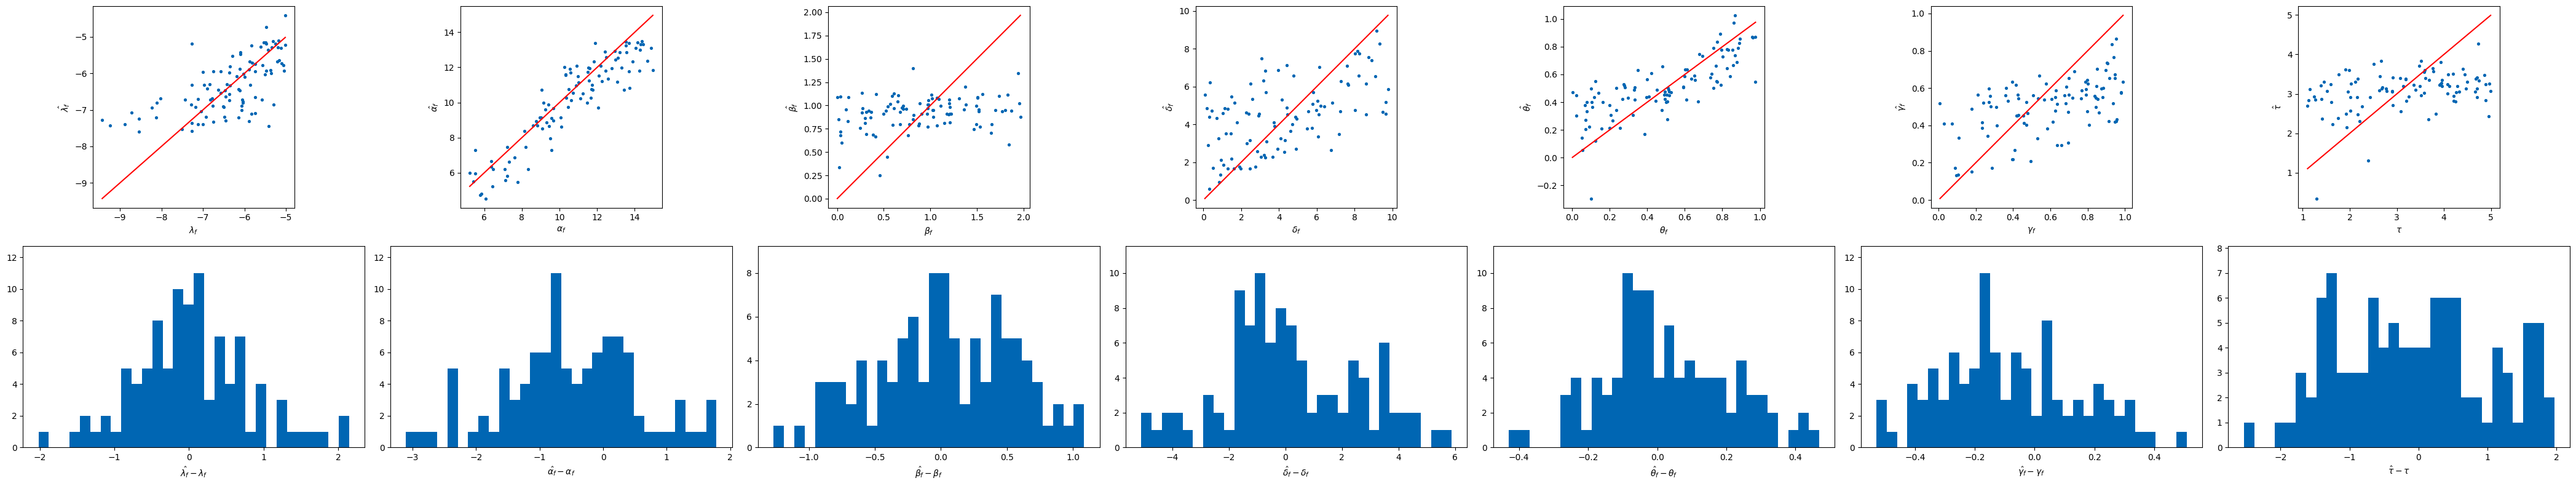

Test results:                    bias         rmse      mean_SD
\lambda_f   0.037 (0.1)  0.770 (0.1)  0.465 (0.0)
\alpha_f   -0.511 (0.1)  1.161 (0.1)  0.681 (0.0)
\beta_f     0.015 (0.1)  0.525 (0.0)  0.907 (0.0)
\delta_f    0.178 (0.2)  2.374 (0.2)  0.408 (0.0)
\theta_f    0.027 (0.0)  0.185 (0.0)  0.427 (0.0)
\gamma_f   -0.085 (0.0)  0.244 (0.0)  0.461 (0.0)
\tau       -0.073 (0.1)  1.081 (0.1)  0.640 (0.0)
[-5.9075489   9.2110405   0.77698827  3.42420888  0.63840091  0.61024439
  2.71588516]
[0.5098519  0.7983891  0.8271841  0.3964754  0.3915194  0.49288756
 0.6305784 ]


In [18]:
R_train, R_test = input_train.shape[0], input_test.shape[0] # num of train/test 'samples'
R = R_train + R_test
M, L = input_train.shape[1], label_train.shape[1]

if args.learn_standard_error:   # sd as labels
    label_train = np.hstack([label_train, np.zeros((R_train, L))])
    label_test = np.hstack([label_test, np.zeros((R_test, L))])
    output_dim = 2 * L
else:
    output_dim = L

scaler = StandardScaler()
input_train, input_test = scaler.fit_transform(input_train), scaler.fit_transform(input_test)
input_real = scaler.fit_transform(input_real.reshape(1, -1))

# Dataset and DataLoader
train_dataset = TensorDataset(torch.tensor(input_train, dtype=torch.float32),
                              torch.tensor(label_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
net = NeuralNet(M, args.num_nodes, output_dim)


device = torch.device("cpu")
net.to(device)
if args.learn_standard_error:
    criterion = forward_loss
else:
    criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=args.initial_lr)

# Optional: learning rate scheduler similar to MATLAB piecewise schedule
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1) # 40, 0.1

for epoch in range(args.max_epochs):
    net.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = net(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    scheduler.step()

# Validation / Test summary (optional)
    net.eval()
    with torch.no_grad():
        test_preds = net(torch.tensor(input_test, dtype=torch.float32))
        loss_va = criterion(test_preds, torch.tensor(label_test, dtype=torch.float32))

    if args.disp_iter:
        print(f"Epoch {epoch + 1}/{args.max_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {loss_va.item():.4f}")


if args.disp_test_summary:
    net.eval()
    with torch.no_grad():
        test_preds = net(torch.tensor(input_test, dtype=torch.float32))
        Test_error_summary(torch.tensor(input_test, dtype=torch.float32), label_test, label_name, net, figure=args.display_fig, table=1)

# Estimate on original data
net.eval()
with torch.no_grad():
    temp = net(torch.tensor(input_real.squeeze(0), dtype=torch.float32)).numpy()

# 截断 theta
theta = np.clip(temp[:L], lb, ub)

# 正向变换标准误（如果学习）
if args.learn_standard_error:
    se = Positive_transform(temp[L:2 * L])

print(theta)
print(se)

特征重要性图已保存至: feature_importance.png


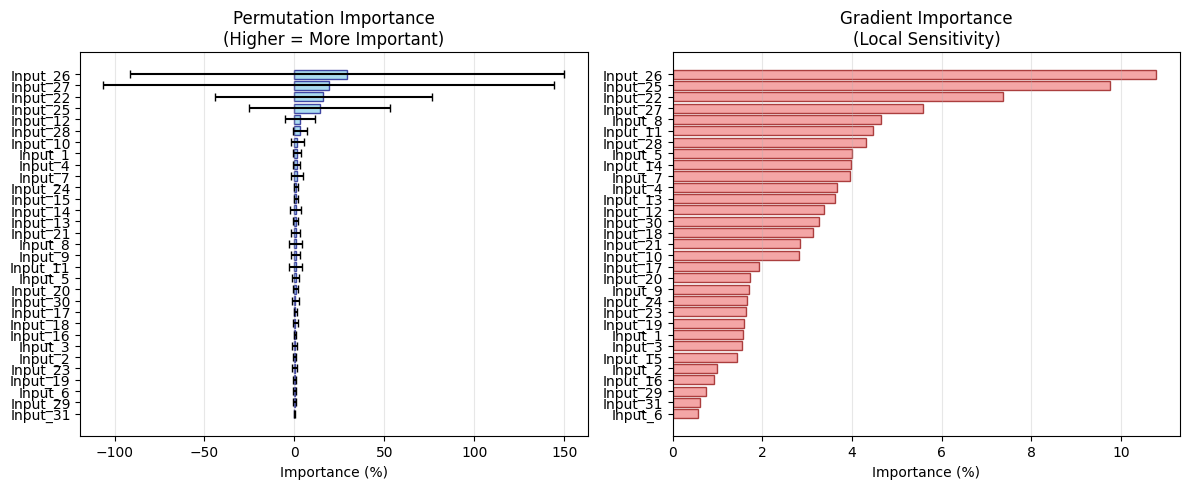


特征重要性评估结果

【排列重要性 - Permutation Importance】
原理：打乱该特征后模型性能下降越多，特征越重要
  1. Input_26       :  29.34% ± 120.72%
  2. Input_27       :  19.03% ± 125.21%
  3. Input_22       :  16.06% ± 60.32%
  4. Input_25       :  13.98% ± 38.99%
  5. Input_12       :   3.14% ±  8.38%
  6. Input_28       :   3.12% ±  4.11%
  7. Input_10       :   1.54% ±  3.51%
  8. Input_1        :   1.51% ±  2.23%
  9. Input_4        :   1.33% ±  1.86%
  10. Input_7        :   1.29% ±  3.32%
  11. Input_24       :   0.85% ±  1.31%
  12. Input_15       :   0.81% ±  1.30%
  13. Input_14       :   0.79% ±  3.12%
  14. Input_13       :   0.73% ±  1.29%
  15. Input_21       :   0.70% ±  2.34%
  16. Input_8        :   0.68% ±  3.78%
  17. Input_9        :   0.66% ±  2.67%
  18. Input_11       :   0.65% ±  3.44%
  19. Input_5        :   0.64% ±  2.06%
  20. Input_20       :   0.60% ±  1.61%
  21. Input_30       :   0.52% ±  2.02%
  22. Input_17       :   0.47% ±  0.71%
  23. Input_18       :   0.47% ±  1.40%
  24. Input_16    

In [19]:
# feature importance analysis

# ==================== 特征重要性评估模块 ====================
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List, Optional, Tuple

class FeatureImportanceAnalyzer:
    def __init__(self, model, device='cpu'):
        self.model = model
        self.device = device
        self.model.eval()
    
    def permutation_importance(self, X: np.ndarray, y: np.ndarray, criterion, 
                              feature_names: Optional[List[str]] = None, 
                              n_repeats: int = 10) -> Tuple[np.ndarray, np.ndarray]:
        """
        排列重要性：随机打乱单个特征，观察模型性能下降程度
        最可靠，计算稍慢但模型无关
        
        Args:
            X: 输入特征 (N, M)
            y: 标签 (N, L) 或 (N,)
            criterion: 损失函数 (如 nn.MSELoss())
            feature_names: 特征名称列表
            n_repeats: 重复次数（减少随机性）
        
        Returns:
            importance_mean: 平均重要性 (%)
            importance_std: 标准差 (%)
        """
        X_tensor = torch.tensor(X, dtype=torch.float32, device=self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32, device=self.device)
        
        # 计算基准性能
        with torch.no_grad():
            baseline_pred = self.model(X_tensor)
            baseline_loss = criterion(baseline_pred, y_tensor).item()
        
        n_features = X.shape[1]
        importances = np.zeros((n_repeats, n_features))
        
        for r in range(n_repeats):
            for i in range(n_features):
                X_permuted = X.copy()
                # 随机打乱第i列（特征）
                perm_idx = np.random.permutation(X.shape[0])
                X_permuted[:, i] = X_permuted[perm_idx, i]
                
                X_perm_tensor = torch.tensor(X_permuted, dtype=torch.float32, device=self.device)
                
                with torch.no_grad():
                    pred = self.model(X_perm_tensor)
                    perm_loss = criterion(pred, y_tensor).item()
                
                # 重要性 = 性能下降幅度 (越大越重要)
                importances[r, i] = perm_loss - baseline_loss
        
        # 计算统计数据
        importance_mean = np.mean(importances, axis=0)
        importance_std = np.std(importances, axis=0)
        
        # 归一化为百分比 (0-100)
        if np.sum(importance_mean) > 0:
            importance_mean = importance_mean / np.sum(importance_mean) * 100
            importance_std = importance_std / np.sum(importance_mean) * 100
        
        return importance_mean, importance_std
    
    def gradient_importance(self, X: np.ndarray, feature_names: Optional[List[str]] = None) -> np.ndarray:
        """
        梯度重要性：计算输入特征的梯度绝对值平均
        速度快，但仅反映局部敏感性
        
        Args:
            X: 输入特征
            feature_names: 特征名称
        
        Returns:
            importance: 重要性数组 (%)
        """
        X_tensor = torch.tensor(X, dtype=torch.float32, device=self.device, requires_grad=True)
        
        self.model.zero_grad()
        output = self.model(X_tensor)
        
        # 对多输出回归，计算各输出绝对梯度的均值
        if output.shape[1] > 1:
            # 计算每个样本输出的均值，然后求梯度
            loss = output.mean()
        else:
            loss = output.mean()
        
        loss.backward()
        
        # 取梯度绝对值的平均
        grads = X_tensor.grad.abs().mean(dim=0).cpu().numpy()
        
        # 归一化
        importance = grads / np.sum(grads) * 100
        
        return importance
    
    def analyze(self, X: np.ndarray, y: np.ndarray, criterion, method: str = 'permutation',
                feature_names: Optional[List[str]] = None, n_repeats: int = 10,
                display: bool = True, save_path: Optional[str] = None) -> dict:
        """
        主分析函数
        
        Args:
            method: 'permutation', 'gradient', 或 'both'
            display: 是否显示图表
            save_path: 保存图表路径 (.png)
        """
        if feature_names is None:
            feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
        
        results = {}
        
        if method in ['permutation', 'both']:
            perm_mean, perm_std = self.permutation_importance(X, y, criterion, feature_names, n_repeats)
            results['permutation_mean'] = perm_mean
            results['permutation_std'] = perm_std
        
        if method in ['gradient', 'both']:
            grad_imp = self.gradient_importance(X, feature_names)
            results['gradient'] = grad_imp
        
        # 可视化
        if display:
            self._plot_importance(results, feature_names, method, save_path)
        
        # 打印排名
        self._print_ranking(results, feature_names, method)
        
        return results
    
    def _plot_importance(self, results: dict, feature_names: List[str], method: str, save_path: Optional[str]):
        """绘制特征重要性图表"""
        n_methods = (1 if 'permutation_mean' in results else 0) + (1 if 'gradient' in results else 0)
        fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))
        if n_methods == 1:
            axes = [axes]
        
        idx = 0
        
        # 排列重要性
        if 'permutation_mean' in results:
            imp = results['permutation_mean']
            std = results.get('permutation_std', None)
            indices = np.argsort(imp)[::-1]
            
            ax = axes[idx]
            y_pos = np.arange(len(feature_names))
            ax.barh(y_pos, imp[indices], xerr=std[indices] if std is not None else None, 
                   capsize=3, alpha=0.7, color='skyblue', edgecolor='navy')
            ax.set_yticks(y_pos)
            ax.set_yticklabels([feature_names[i] for i in indices])
            ax.invert_yaxis()
            ax.set_xlabel('Importance (%)')
            ax.set_title('Permutation Importance\n(Higher = More Important)')
            ax.grid(axis='x', alpha=0.3)
            idx += 1
        
        # 梯度重要性
        if 'gradient' in results:
            imp = results['gradient']
            indices = np.argsort(imp)[::-1]
            
            ax = axes[idx]
            y_pos = np.arange(len(feature_names))
            ax.barh(y_pos, imp[indices], alpha=0.7, color='lightcoral', edgecolor='darkred')
            ax.set_yticks(y_pos)
            ax.set_yticklabels([feature_names[i] for i in indices])
            ax.invert_yaxis()
            ax.set_xlabel('Importance (%)')
            ax.set_title('Gradient Importance\n(Local Sensitivity)')
            ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"特征重要性图已保存至: {save_path}")
        
        if args.display_fig:
            plt.show()
        else:
            plt.close()
    
    def _print_ranking(self, results: dict, feature_names: List[str], method: str):
        """打印重要性排名"""
        print("\n" + "="*50)
        print("特征重要性评估结果")
        print("="*50)
        
        if 'permutation_mean' in results:
            print("\n【排列重要性 - Permutation Importance】")
            print("原理：打乱该特征后模型性能下降越多，特征越重要")
            perm_imp = results['permutation_mean']
            perm_std = results.get('permutation_std', np.zeros_like(perm_imp))
            indices = np.argsort(perm_imp)[::-1]
            
            for rank, idx in enumerate(indices, 1):
                print(f"  {rank}. {feature_names[idx]:15s}: {perm_imp[idx]:6.2f}% ± {perm_std[idx]:5.2f}%")
        
        if 'gradient' in results:
            print("\n【梯度重要性 - Gradient Importance】")
            print("原理：输入梯度越大，输出对该特征越敏感")
            grad_imp = results['gradient']
            indices = np.argsort(grad_imp)[::-1]
            
            for rank, idx in enumerate(indices, 1):
                print(f"  {rank}. {feature_names[idx]:15s}: {grad_imp[idx]:6.2f}%")
        print("="*50)


# ==================== 使用示例（放在你的代码末尾） ====================

# 1. 初始化分析器
analyzer = FeatureImportanceAnalyzer(net, device)

# 2. 定义特征名称（可选，建议根据实际问题定义）
feature_names = [f'Input_{i+1}' for i in range(M)]  # 或自定义名称如 ['温度', '压力', '流量', ...]

# 3. 执行分析（推荐 method='permutation' 或 'both'）
# 注意：使用 label_test 作为目标，如果 label_test 是二维的，criterion 需要能处理
results = analyzer.analyze(
    X=input_test,
    y=label_test,
    criterion=criterion,
    method='both',              # 'permutation', 'gradient', 或 'both'
    feature_names=feature_names,
    n_repeats=10,               # 排列重复次数（越多越稳定，但越慢）
    display=True,               # 是否显示图表
    save_path='feature_importance.png'  # 保存路径，设为None不保存
)

# 4. 获取最重要的前K个特征（用于后续分析）
top_k = 5
if 'permutation_mean' in results:
    top_indices = np.argsort(results['permutation_mean'])[::-1][:top_k]
    print(f"\n最重要的{top_k}个特征索引: {top_indices}")
    print(f"对应的特征名称: {[feature_names[i] for i in top_indices]}")

# 5. 可选：基于重要性进行特征选择（移除低重要性特征）
threshold = 1.0  # 重要性阈值 (%)
if 'permutation_mean' in results:
    important_mask = results['permutation_mean'] > threshold
    selected_features = np.where(important_mask)[0]
    print(f"\n重要性 > {threshold}% 的特征索引: {selected_features}")
    print(f"建议保留 {len(selected_features)}/{M} 个特征")